# 선형회귀 실습 - 공유자전거 대여 수요 예측

캐글의 자전거 대여 수요 데이터셋을 활용하여 선형회귀 예측모델을 만드는 과정을 실습해보겠습니다. 데이터세트는 https://www.kaggle.com/c/bike-sharing-demand/data에서 내려받을 수 있습니다. train.csv 파일만 다운받아서 노트북 폴더에 복사해 둡니다.

![](https://imgdb.in/k7rr.jpg)

위 데이터세트는 2011년 1월부터 2012년 12월까지 2년동안 매일 1시간 간격으로 자전거 대여 횟수를 기록한 자료입니다. 데이터세트의 칼럼은 아래와 같습니다.

- datetime : 날짜 + 시각(1시간 간격)
- season : 계절(봄여름가을겨울 순으로 1, 2, 3, 4)
- holiday : 휴일이면 1, 휴일이 아니면 0(주말은 0)
- workingday : 주중이면 1, 주말이나 휴일이면 0
- weather : 날씨(1-맑거나 약간 구름, 2-안개, 3-가벼운 눈이나 비, 4-심한 눈이나 천둥번개)
- temp : 온도(섭씨)
- atemp : 체감온도(섭씨)
- humidity : 상대습도
- windspeed : 풍속(단위?)
- casual : 미등록 사용자(비회원) 대여횟수
- registered : 등록회원 대여횟수
- count : 대여횟수(예측대상)

본격적으로 예측작업을 하기 전에 데이터 탐색을 한 번 해 봅시다.

In [161]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.read_csv("./train.csv")
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


10886개의 행과 12개의 칼럼으로 구성되어 있네요. 다행히 Null 데이터도 없고요.

0번 행인 datetime을 보면 자료형이 "object"입니다. "연-월-일 시:분:초" 형식의 문자열로 구성되어 있는데, [연, 월, 일, 시] 네 개의 칼럼으로 분리하도록 하겠습니다. (분과 초는 0이므로 무시합시다.)

In [162]:
# 연월일시 추출방법
df["datetime"] = df.datetime.apply(pd.to_datetime)  # 파이썬에서 제공하는 datetime 인스턴스로 변경
df["year"] = df.datetime.apply(lambda x: x.year)
df["month"] = df.datetime.apply(lambda x: x.month)
df["day"] = df.datetime.apply(lambda x: x.day)
df["hour"] = df.datetime.apply(lambda x: x.hour)

df.drop(["datetime"], inplace=True, axis=1)  # datetime 열 제거
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [42]:
# 위의 연월일시 변환 코드를 이해하기 위한 예시

import datetime as dt

sample = "2011-01-01 00:00:00"
converted_sample = dt.datetime.strptime(sample, "%Y-%m-%d %H:%M:%S")
print(converted_sample)
print(converted_sample.month)  # 각각의 요소를 인식할 수 있음. month값만 출력

2011-01-01 00:00:00
1


또 한 가지, casual과 registered는 합하면 count가 됩니다. 즉, 상관도가 높아 예측을 저해할 우려가 있어서 깔끔하게 지워버려도 되지만, 욱하는 마음에 자전거를 타버리는(?) 비회원 비율이 예측에 도움이 될까 싶기도 한데요. 한 번 상관관계를 알아볼까요?

In [156]:
df["ratio"] = df["casual"] / df["registered"]
df["ratio"].describe()

count    1.088600e+04
mean              inf
std               NaN
min      0.000000e+00
25%      6.574394e-02
50%      1.692308e-01
75%      3.394495e-01
max               inf
Name: ratio, dtype: float64

scatter플롯으로 시각화해서 count와 ratio의 상관관계를 한 번 확인해봅시다.

<AxesSubplot:xlabel='ratio', ylabel='count'>

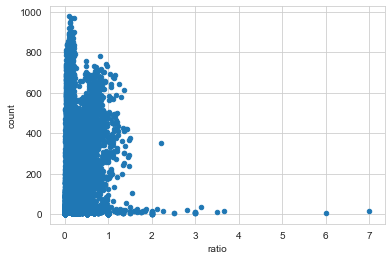

In [157]:
df.plot.scatter("ratio", "count")

In [69]:
df[["casual", "registered", "ratio", "count"]].corr()

,casual,registered,ratio,count
casual,1.000000,0.497250,0.505726,0.690414
registered,0.497250,1.000000,-0.052397,0.970948
ratio,0.505726,-0.052397,1.000000,0.095852
count,0.690414,0.970948,0.095852,1.000000


ratio와 count의 상관관계는 약 0.096 정도입니다. 0에 아주 가까운, 아무 짝에도 쓸모없는 관계를 갖고 있군요. ratio는 사용하지 말아야겠습니다.

In [70]:
df.drop(["ratio"], inplace=True, axis=1)

이참에 아예 모든 칼럼별로 어떤 값에 count가 많이 들어가는지 시각화해봅시다.
(주의: 시간이 상당히 걸림)

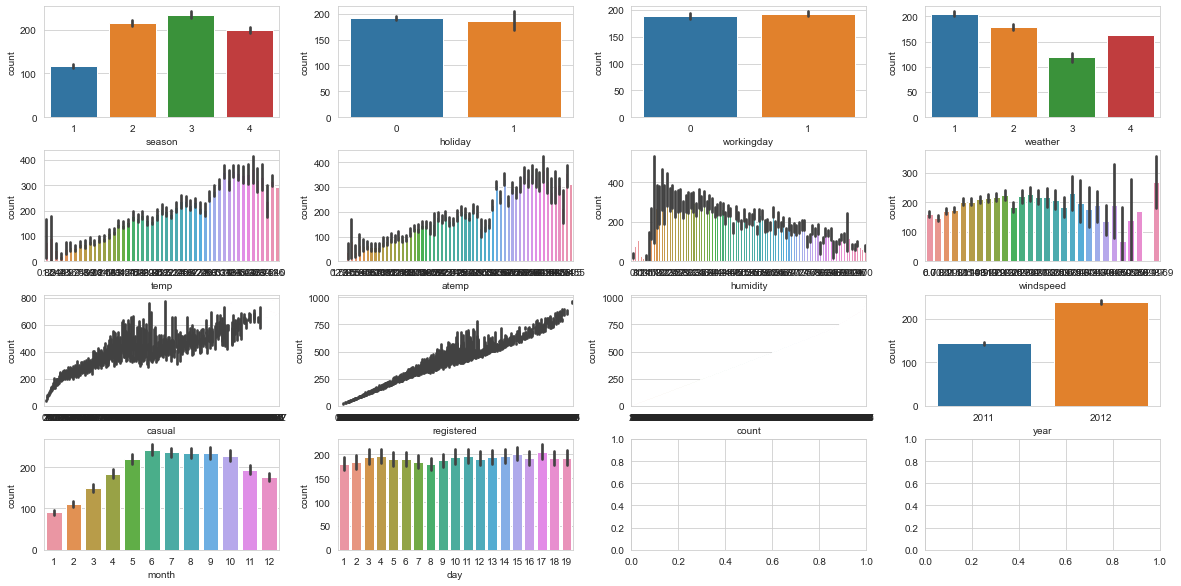

In [9]:
fig, ax = plt.subplots(figsize=(20, 10), ncols=4, nrows=4)
cat_features = df.columns.tolist()[:-1]
for idx, feature in enumerate(cat_features):
    row = int(idx // 4)
    col = idx % 4
    sns.barplot(x=feature, y="count", data=df, ax=ax[row][col])
fig.subplots_adjust(wspace=0.25, hspace=0.3)

In [163]:
from sklearn.model_selection import train_test_split  # 과적합 방지를 위한 훈련/테스트데이터 분리 함수
from sklearn.linear_model import LinearRegression  # sklearn에서 제공하는 기본 선형회귀모델 클래스
from sklearn.metrics import mean_squared_error  # 평균제곱오차MSE 함수


def rmse(y, pred):  # Root Mean Squared Error(평균제곱근오차)
    return np.sqrt(mean_squared_error(y, pred))  # 단순히 MSE에 루트만 씌우면 됨.

X_features = df.drop(["count"], axis=1, inplace=False)  # 타겟값인 count를 배제한 모든 특성을 사용 예정
y_target = df["count"]  # 타겟값만 별도의 변수로 분리

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3)  # 훈련/테스트 데이터 비율 70:30

In [164]:
lr = LinearRegression()  # lr이라는 선형회귀 인스턴스 생성(클래스 문법)
lr.fit(X_train, y_train)  # 반복훈련 실행
predict = lr.predict(X_test)  # 예측
print(rmse(y_test, predict))  # RMSE를 평가지표로 사용

1.1271058523561528e-13


(random_state를 지정하지 않아서 값에 변동이 있음)
0.0000000000001 ????
이상하리만큼 오차가 0에 가깝네요...?
이럴 땐 무조건 잘못되었다고 의심을 해봐야 합니다.

In [49]:
# 실제 대여값과 예측 대여값의 차이가 많이 나는 순서대로 출력
result_df = pd.DataFrame(y_test.values, columns=['real_count'])
result_df['predicted_count']= np.round(predict)
result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

result_df.sort_values('diff', ascending=False)[:20]

,real_count,predicted_count,diff
0,166,166.0,0.0
2181,199,199.0,0.0
2171,53,53.0,0.0
2172,710,710.0,0.0
2173,524,524.0,0.0
2174,198,198.0,0.0
2175,95,95.0,0.0
2176,113,113.0,0.0
2177,84,84.0,0.0
2178,321,321.0,0.0


이건 뭐 완전히 동일한 값이 나와버리네요? 왜 그럴까요?
앞에서 언급했지만, casual + registered = count이기 때문입니다.
선형회귀로 학습한 가중치를 한 번 확인해보겠습니다.

In [50]:
lr.coef_

array([ 7.74727120e-15,  3.69583588e-13, -2.46140202e-14,  1.62931399e-14,
       -2.02541445e-15,  3.36250703e-15, -1.07851167e-15,  3.61585849e-16,
        1.00000000e+00,  1.00000000e+00, -2.71996125e-15,  1.22464615e-15,
       -9.73889746e-17, -4.63511791e-16])

8번과 9번 칼럼(casual & registered)만 가중치가 1로 학습되고, 나머지 특성들은 모두 0으로 수렴하였습니다..
대략 아래와 같은 식이 나와버렸네요..

$$1 * x_{casual} + 1 * x_{registered} = 예측값$$

그런데, 조금만 생각해봐도 casual과 registered는 사후에 집계된 숫자일 뿐, 예측시점에는 절대 취득할 수 없는 값이기 때문에
이 두 개의 특성은 (겸허히) 예측모델에서 배제한 후에 다시 만드는 게 좋겠습니다.
동일한 과정으로 선형회귀 모델을 다시 학습해보겠습니다.

In [51]:
X_features = df.drop(["casual", "registered", "count"], axis=1, inplace=False)  # casual과 registered 특성도 제거
y_target = df["count"]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)  # 가중치 학습
predict = lr.predict(X_test)  # 예측값 계산
print(rmse(y_test, predict))  # 평균제곱근오차RMSE 계산

144.87631457956562


모르긴 몰라도 144라는 (엄청나게 큰) 숫자가 튀어나왔습니다ㄷㄷ
어느 정도 오차인지 잘 감이 오지 않을 수 있으니,
비교적 우리에게 익숙한 결정계수($R^2$)로 확인해볼까요?

In [52]:
lr.score(X_test, y_test)  # 결정계수 R^2을 계산해주는 메서드

0.38317031197628826

실제 y값과 예측한 값과의 상관관계가 0.38 정도면, 거의 쓸모없는 것 같은데요?
14개의 특성으로 y값을 고작 38% 정도 밖에 설명할 수 없는 모델이라뇨ㅜ
그래도 좌절하지 말고 모델을 개선해봅시다.

넘어가기 전에 $R^2$나 RMSE가 실제 어느 정도의 오차를 의미하는지
와닿지 않을 수도 있기 때문에
실제값과 예측값의 차이를 실제로 한 번 확인해보겠습니다.

In [53]:
result_df = pd.DataFrame(y_test.values, columns=['real_count'])  # 실제 대여횟수로 df생성
result_df['predicted_count']= np.round(predict)  # 예측 대여횟수 칼럼 추가
result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])  # 차잇값 칼럼 추가

result_df.sort_values('diff', ascending=False)[:20]  # 가장 오차가 큰 20개 행 출력

,real_count,predicted_count,diff
694,784,182.0,602.0
2829,731,143.0,588.0
354,948,364.0,584.0
747,917,337.0,580.0
1109,890,325.0,565.0
1906,968,405.0,563.0
1342,677,125.0,552.0
2157,745,194.0,551.0
345,797,246.0,551.0
2835,813,265.0,548.0


<AxesSubplot:xlabel='real_count', ylabel='predicted_count'>

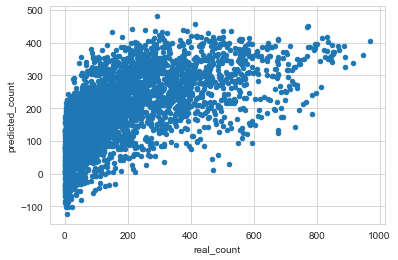

In [54]:
result_df.plot.scatter("real_count", "predicted_count")

개판이네요..
(예측값 중 가장 많이 빗나간 값이긴 하지만) "784대"를 빌려간 날의 예측값이 "182대"이니 못써먹겠네요.
그래도 어떻게든 잘 보완해서 성능을 끌어올려봐야 하지 않겠습니까?

회귀에서 이렇게 큰 오류가 발생하는 경우 가장 먼저 확인해야 할 것은 "타겟 값의 분포"입니다. 타겟값이 미려한 정규분포곡선을 띠고 있으면 제일 좋은데, 이런 경우는 정말 흔하지 않죠.

<AxesSubplot:>

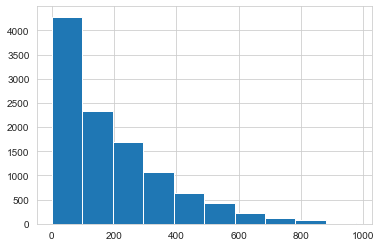

In [55]:
y_target.hist()

이런 히스토그램이라면, 로그변환을 한 번 해보면 정규분포 형태를 띠기도 합니다.

<AxesSubplot:>

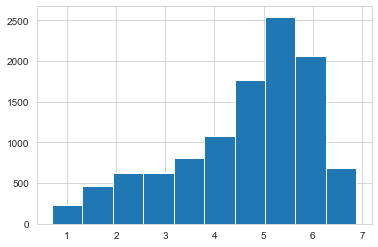

In [56]:
y_log = np.log1p(y_target)  # 입력값이 0에 수렴할 때 -inf가 되는 경우를 방지하기 위해 1을 더한 후(1p) 로그를 취함
y_log.hist()

(반대쪽으로 쏠려버린 느낌이 없잖아 있지만...)
변환하기 전보다는 훨씬 나은 모양이네요.
이걸로 다시 학습한 후 평가해보겠습니다.
마지막엔 로그로 변환했던 값을 exp로 복원해야 하는 과정 꼭 잊지 마세요!

In [57]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3)
lr = LinearRegression()
lr.fit(X_train, y_train)
predict = lr.predict(X_test)

y_test = np.expm1(y_test)  # 원래 스케일로 변환(복원). 로그 취할 때 1을 더했으므로 복원 때는 1을 다시 빼줘야 함("m1"="Minus 1")
predict = np.expm1(predict)  # 로그변환된 타겟값을 기반으로 예측했으므로 예측값도 스케일 복원

rmse(y_test, predict)

157.35812563146843

점입가경이네요.. RMSE가 더 커졌습니다ㅜㅜㅜ (144->157?)
뭐가 문제인지 가중치를 다시 점검해봅시다..

<AxesSubplot:>

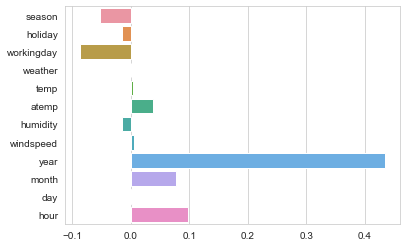

In [58]:
coef = pd.Series(lr.coef_, index=X_features.columns)
sns.barplot(x=coef.values, y=coef.index)

이건 뭐죠? 가장 영향이 큰 가중치(계수)가 year 특성이네요?
"그깟 2011, 2012가 가장 영향도가 높다고...?"
...라고 생각하실 수 있지만 이게 말이 되는 게,
아래 그래프를 보시면 이해가 될 겁니다.

<AxesSubplot:xlabel='year', ylabel='count'>

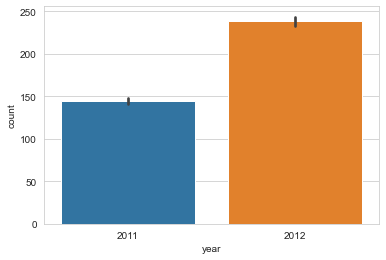

In [59]:
sns.barplot(x="year", y="count", data=df)

2012년에는 자전거 대여횟수가 훅 늘었어요. 두 배 가까이 늘었네요.
그래서 우리 모델도 2012년이면 대여횟수가 크고, 2011년에는 대여횟수가 적다고 해석한 거겠죠.
> 광고를 많이 해서인지, 점차 대중화가 되고 있어서인지.. 알게 뭐람ㅜ

# 이쯤에서 우리가 간과하고 있던..
(미리 눈치채신 분도 많겠지만)
## 아주 중요한 사실 한 가지를 알려드리겠습니다.

우리 선형회귀 모델은 12(월)을 1(월)보다 중요하게 생각하는 경향이 있어요.
30(일)을 01(일)보다 30배 크다고 인식하고, 겨울(4)이 봄(1)보다 네 배 정도 크다고 여겨요.
컴퓨터는 연월일시나 계절을 카테고리처럼 인식하지 않고, 크기비교 가능한 숫자라고 인식해버리기 때문에
숫자로 된 값에 영향을 크게 받아요.

## 원핫인코딩이 필요한 시점

그래서 이들을 모두 카테고리형 특성으로 변환해줘야 해요.
가장 많이 사용하는 기법, 일종의 트릭인 "원-핫 인코딩"을 적용해보겠습니다.

> "하나만 뜨거운 인코딩이라고?"

예, 맞습니다. 예를 들어,
season 칼럼에는 봄부터 겨울까지 1~4의 정수가 들어있는데,
원핫인코딩을 적용하면 season 칼럼이
season_1, season_2, season_3, season_4 라는 네 개의 칼럼으로 바뀌고
season_1 칼럼에는 봄(1)인 행에만 1, 나머지 행에는 0이 들어가게 됩니다.

판다스에서 제공하는 get_dummies를 사용하여
범주형이라고 생각되는 모든 특성에 원핫인코딩을 적용하겠습니다.

In [166]:
X_features = pd.get_dummies(X_features, columns=["year", "month", "day", "hour", "holiday", "workingday", "season", "weather"])
X_features.info()  # 특성이 72개로 훅 늘어납니다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 73 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          10886 non-null  float64
 1   atemp         10886 non-null  float64
 2   humidity      10886 non-null  int64  
 3   windspeed     10886 non-null  float64
 4   year_2011     10886 non-null  uint8  
 5   year_2012     10886 non-null  uint8  
 6   month_1       10886 non-null  uint8  
 7   month_2       10886 non-null  uint8  
 8   month_3       10886 non-null  uint8  
 9   month_4       10886 non-null  uint8  
 10  month_5       10886 non-null  uint8  
 11  month_6       10886 non-null  uint8  
 12  month_7       10886 non-null  uint8  
 13  month_8       10886 non-null  uint8  
 14  month_9       10886 non-null  uint8  
 15  month_10      10886 non-null  uint8  
 16  month_11      10886 non-null  uint8  
 17  month_12      10886 non-null  uint8  
 18  day_1         10886 non-nu

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3)
lr = LinearRegression()
lr.fit(X_train, y_train)
predict = lr.predict(X_test)

y_test = np.expm1(y_test)  # 원래 스케일로 변환(복원)
predict = np.expm1(predict)  # 로그변환된 타겟값을 기반으로 예측했으므로 예측값도 스케일 복원

rmse(y_test, predict)

92.14583971302538

오, 오차가 절반 가까이 줄어들었습니다.
뭔가 숫자가 세자리에서 두자리가 되니까 성능이 (엄청) 좋아진 것처럼 느껴지네요!
결정계수도 (이번엔 다른 방식으로) 계산해볼까요?

In [75]:
from sklearn.metrics import r2_score


r2_score(y_test, predict)  # lr.score 메서드 내부에서도 동일한 r2_score 함수를 사용함

0.7415709373455441

영향력이 큰 계수는 어떻게 바뀌었는지 다시 확인해볼까요?

In [85]:
lr.coef_

array([ 8.93329043e-03,  1.69907353e-02, -3.31612309e-03, -3.83717687e-03,
       -6.28473867e+09, -6.28473867e+09,  1.42004276e+09,  1.42004277e+09,
        1.42004277e+09, -3.62450323e+09, -3.62450323e+09, -3.62450323e+09,
        2.77584759e+09,  2.77584759e+09,  2.77584759e+09,  1.11095218e+07,
        1.11095218e+07,  1.11095217e+07, -4.66969665e+08, -4.66969665e+08,
       -4.66969665e+08, -4.66969665e+08, -4.66969665e+08, -4.66969665e+08,
       -4.66969665e+08, -4.66969665e+08, -4.66969665e+08, -4.66969665e+08,
       -4.66969665e+08, -4.66969665e+08, -4.66969665e+08, -4.66969665e+08,
       -4.66969665e+08, -4.66969665e+08, -4.66969665e+08, -4.66969665e+08,
       -4.66969665e+08, -1.51854534e+08, -1.51854535e+08, -1.51854536e+08,
       -1.51854536e+08, -1.51854536e+08, -1.51854535e+08, -1.51854534e+08,
       -1.51854533e+08, -1.51854533e+08, -1.51854533e+08, -1.51854533e+08,
       -1.51854533e+08, -1.51854533e+08, -1.51854533e+08, -1.51854533e+08,
       -1.51854533e+08, -

year만 압도적으로 높았던 이전 모델과 달리 날씨나 월, 계절, 연도, 주말여부 등의 특성이 골고루 영향도를 보임을 확인할 수 있습니다. 시각화해서 확인해볼까요?

<AxesSubplot:>

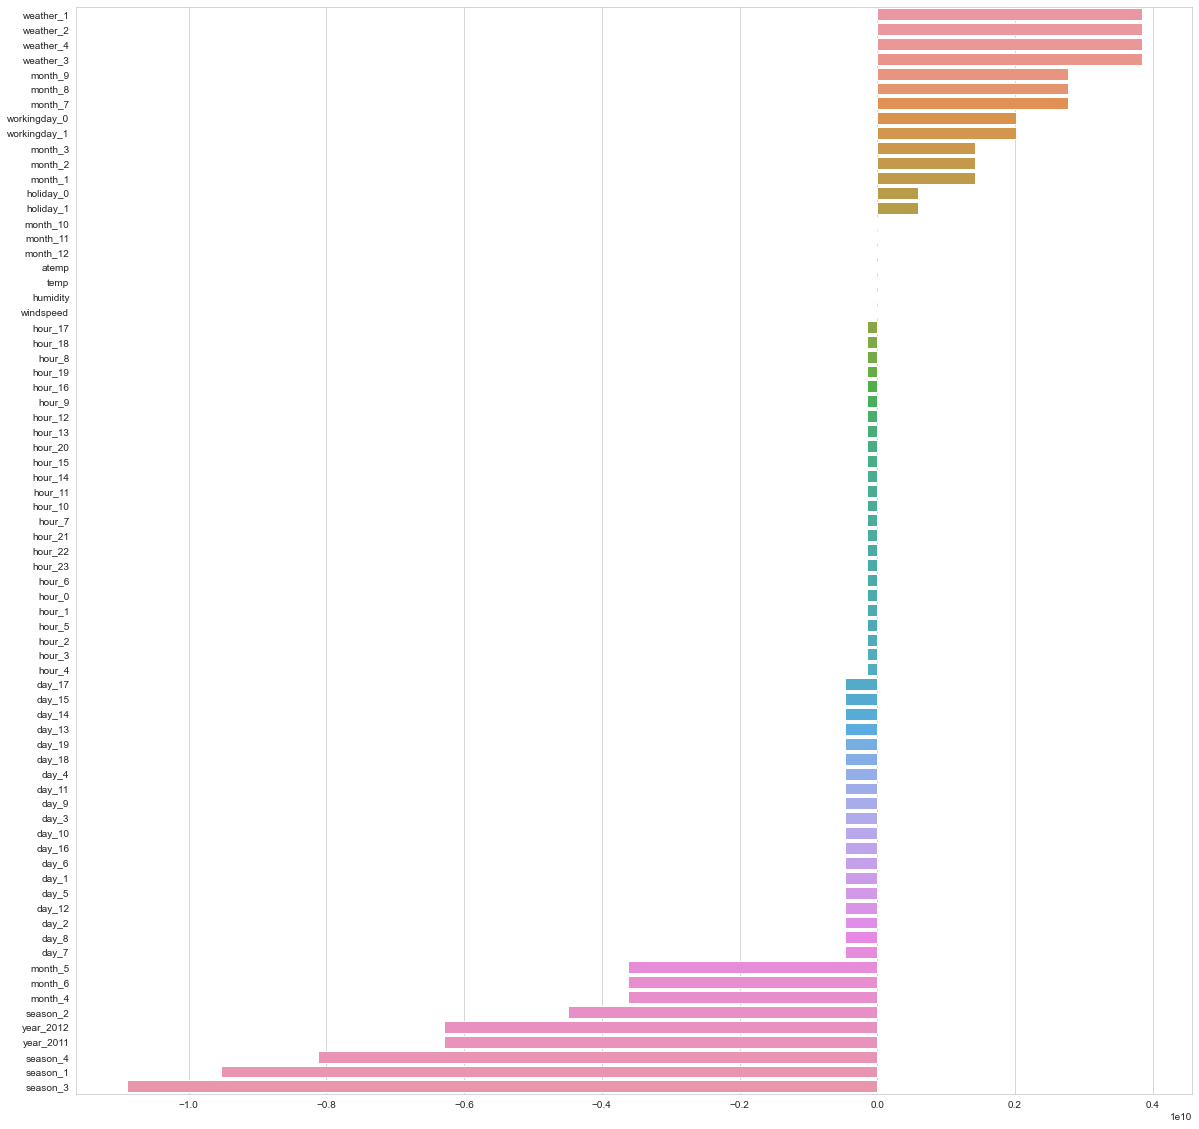

In [86]:
coef = pd.Series(lr.coef_, index=X_features.columns).sort_values(ascending=False)
plt.figure(figsize=(20,20))
sns.barplot(x=coef.values, y=coef.index)

위에서 실행했던, 예측값과 실제값의 차이를 다시 알아보겠습니다.

In [87]:
result_df = pd.DataFrame(y_test.values, columns=['real_count'])
result_df['predicted_count']= np.round(predict)
result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

# result_df.sort_values('diff', ascending=False)[:20]  # 오차가 너무 커 보여 생략
result_df.sort_values('diff', ascending=True)[:100]

,real_count,predicted_count,diff
3250,5.0,5.0,0.0
980,5.0,5.0,0.0
1114,11.0,11.0,0.0
601,12.0,12.0,0.0
2146,12.0,12.0,0.0
...,...,...,...
921,1.0,2.0,1.0
1074,5.0,6.0,1.0
853,5.0,4.0,1.0
1489,5.0,6.0,1.0


Text(0, 0.5, 'predicted value')

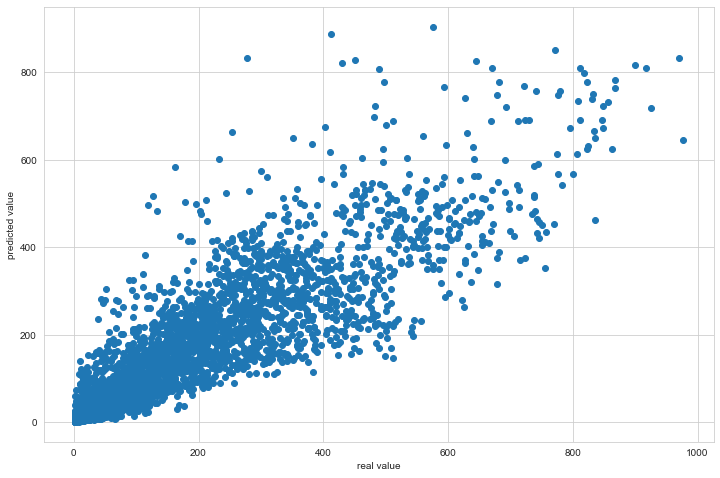

In [92]:
plt.figure(figsize=(12,8))
plt.scatter(y_test, predict)
plt.xlabel("real value")
plt.ylabel("predicted value")

여전히 완벽한 모델은 아니지만, 제법 준수한 예측을 해 주는 것 같습니다.
선형회귀 모델을 유지한 채로 성능을 더 끌어올리려면,
지속적으로 데이터를 더 많이 확보하거나
그리드서치로 하이퍼파라미터를 최적화해보기도 하고
다항polynomial회귀와 규제-Ridge, Lasso 등을 적용해볼 수도 있고
(범주형으로 전부 때려넣었던) 기간정보 등을 통해 시계열에 따른 경향을 고려해볼 수도 있겠습니다.
(다만, 대체로 성능향상은 경미합니다.)

마지막으로 이 데이터셋에서 가장 높은 성능을 보이는 "앙상블 모델"로도 학습을 해보겠습니다.

가장 인기가 많은 라이브러리인 XGBoost, 마이크로소프트에서 제작한 lightgbm과
사이킷런에서 기본적으로 제공하는 랜덤포레스트, 그래디언트 부스팅 모델 등
성능이 뛰어나다는 회귀(트리)모델을 전부 가져와서 학습을 돌려보겠습니다.

> 참고로 앙상블모델은 기존의 단순한 모델을 여러 개(수백~수천) 만들고 각각의 예측값 또는 오답여부, 오차 등의 정보를 이용해 여러 방법으로 조합하여 최적의 예측값을 도출하는 기법입니다. 일종의 "집단지성"같은 모델입니다. 이들의 평균을 낸다든지(회귀), 투표를 한다든지(분류) 등의 방식으로 정확도도 끌어올리면서 과적합도 적당히 방지하는, (딥러닝을 제외하고는) 가장 인기가 많은 모델이기도 합니다.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FFthOe%2FbtqGn0AeoUy%2FKWkOHKAEz2MSfchuxNxQJ0%2Fimg.png" width=900>

In [26]:
!pip install xgboost lightgbm  # 외부 라이브러리이므로 설치 필요

In [95]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



model = RandomForestRegressor(n_estimators=500)
gbm = GradientBoostingRegressor(n_estimators=500)
xgb = XGBRegressor(n_estimators=500)
model = LGBMRegressor(n_estimators=500)

for model in [rf, gbm, xgb, lgbm]:
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3)
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    y_test = np.expm1(y_test)  # 원래 스케일로 변환(복원)
    predict = np.expm1(predict)  # 로그변환된 타겟값을 기반으로 예측했으므로 예측값도 스케일 복원
    print(model)
    print("rmse : ", rmse(y_test, predict))
    print("r2_score : ", r2_score(y_test, predict))
    print("\n\n")

RandomForestRegressor(n_estimators=500)
rmse :  46.41781058521262
r2_score :  0.9331307360060586



GradientBoostingRegressor(n_estimators=500)
rmse :  55.01454661712772
r2_score :  0.9061237436851683



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
rmse :  52.98193632397359
r2_score :  0.914532481817359



LGBMRegressor(n_estimators=500)
rmse :  44.02922

앙상블 모델들은 대체로 40 부근의 준수한 RMSE 값, 0.9 이상의 R2 값이 나왔네요.
(이것이 집단지성의 힘인가요ㄷㄷㄷ)

항상 앙상블(회귀 트리)가 선형회귀보다 뛰어난 성능을 보이는 것은 아닙니다.
(그렇지만 거의 대부분의 경우에 뛰어나기는 합니다ㅜ)
데이터세트 유형에 따라 얼마든지 결과가 달라질 수 있어
여러 개의 가벼운 모델로도 예측을 시도해보는 습관을 가지는 것이 좋습니다.

# 학습완료된 모델을 로컬에 저장하기

학습한 모델 객체를 저장할 때는 joblib 또는 (파이썬에서 기본제공하는) pickle 모듈을 사용합니다.
선형회귀 모델 lr은 joblib으로, lightGBM 모델은 pickle로 저장해보겠습니다.

In [148]:
# 학습완료된 모델을 로컬에 저장(joblib 사용)
import joblib


joblib.dump(lr, 'bikeshare_linearregression#20220721.sav') # 모델을 파일로 저장

['bikeshare_linearregression#20220721.sav']

In [149]:
# 학습완료된 lightGBM 모델을 로컬에 저장(pickle 사용)
import pickle


filename2 = 'bikeshare_lightgbm#20220721.pickle'
with open(filename2, "wb") as f:
    pickle.dump(model, f)

간편하게 저장이 완료되었습니다.
이제 이 파일을 통해 모델을 불러오는 과정을 보여드리겠습니다.

In [150]:
# joblib으로 파일에서 모델객체 불러오기
lr_model = joblib.load('bikeshare_linearregression#20220721.sav')
lr_model

LinearRegression()

In [151]:
# pickle로 파일에서 모델객체 불러오기
with open(filename2, "rb") as f:  # Read Binary
    lgbm_model = pickle.load(f)

lgbm_model

LGBMRegressor(n_estimators=500)

# 공유자전거 수요 예측하기

## 입력데이터 준비

In [153]:
example = np.array(X_test.iloc[0]).reshape(-1, 1).T  # model.predict 메서드는 열갯수가 중요하므로 전치(T)로 열벡터로 바꿈
print(example)  # 기온 섭씨15.58도, 체감기온 19.7도, 상대습도 76% 등등

[[15.58  19.695 76.     0.     0.     1.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     1.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     1.     0.     0.     1.     0.     0.     0.     1.     1.
   0.     0.     0.   ]]


## 불러온 선형회귀 모델로 예측하기

In [145]:
np.expm1(lr_model.predict(example))  # 선형회귀

array([22.62960515])

## 불러온 LightGBM 모델로 예측하기

In [152]:
np.expm1(lgbm_model.predict(example))  # LightGBM

array([5.60686302])

# 예측결과

2012년 10월 17일(수) 겨울 새벽 두 시,
날씨는 맑고, 기온은 섭씨 15.6도, 체감온도 19.7도, 상대습도 76%일 때 새벽2시~3시 대여 예측량은,
선형회귀는 **약 23대** 정도로, LightGBM은 **약 6대** 정도로 예측하네요.
(해당 시간에 실제로는 **16대**를 대여했습니다.)

> 실제로 머신러닝 서비스는 데이터 적재나 예측 때 DB를 연동한 일종의 "파이프라인"을 구축해놓습니다.
> 간단한 숫자 하나를 예측하는데 73개나 되는 숫자를 손으로 직접 전처리하고 입력하기는 쉽지 않죠.

오늘 온라인 미팅은 여기서 마치겠습니다.
다음 시간에 뵙겠습니다!

수고하셨습니다!